# Spatial Autocorrelation: Join Counts

This python notebook introduces the Join Counts method for measuring **spatial autocorrelation**, using the [`Join_Counts` function](https://pysal.org/esda/generated/esda.Join_Counts.html#esda.Join_Counts) from the [PySAL esda module](https://pysal.org/esda/index.html). It provides an <a href="#overview">overview of spatial autocorrelation</a> before presenting <a href="#theory">the theory</a> (based on O'Sullivan and Unwin **2003**) and an <a href="#applied">applied example</a> (based on Rey *et al.* 2020) of the join counts method. 

## Spatial Autocorrelation <a name="overview"></a>
Autocorrelation is correlation of a variable with its lagged self. In the sense used here, lag can be thought of as an offset, and when spatial autocorrelation is considered a lag is a distance across space. 

So, spatial autocorrelation is a quantitative measure of similarity between observations at different locations of a single variable. Contrast this *auto*correlation with normal correlation, which is a measure of similarity between observations of two variables at the same locations. 

Spatial autocorrelation provides a means to quantify the existence of Tobler's 'First Law' that,

> Everything is related to everything else, but near things are more related than distant things.

Tobler's First Law implies *positive* spatial autocorrelation, and we can think of observations of similar values as being clustered. The opposite - when distant things are more similar than near things - is known as *negative* spatial autocorrelation and we can thinking of observations of similar values as being dispersed. Negative spatial autocorrelation is quite rare in real world geographical observations. An *absence* of spatial autocorrelation implies there is no spatial structure and that a variable is distributed randomly across space. 

With respect to spatial autocorrelation, often in geography and spatial data science we want to know:

1. Is there *any* spatial structure? (i.e. can we say a variable is *not* randomly distributed?)
2. If there is spatial structure, what *type* is it? (i.e. positive or negative?) 
3. If there is spatial structure, how *strong* is it (i.e. how tightly clustered or broadly dispersed are values?)

Spatial statistics in spatial data science provide various tools to answer these questions, including the Joins Count test for spatial autocorrelation (examined in this notebook) and Moran's I (examined in another notebook). We can also consider spatial autocorrelation *globally* across and entire data set, or *locally* for individual observations.

[Section 2.2 of O'Sullivan and Unwin (2010)](https://ebookcentral.proquest.com/lib/kcl/reader.action?docID=4945124&ppg=58) provides further introduction to the concept of spatial autocorrelation, with [section 7.4](https://ebookcentral.proquest.com/lib/kcl/reader.action?docID=4945124&ppg=223) providing more detail. Also see [Rey *et al.* (2020)](https://geographicdata.science/book/notebooks/06_spatial_autocorrelation.html). 

# Theory of Join Counts <a name="theory"></a>
The joins count test for spatial autocorrelation was developed by [Cliff and Ord (1973)](https://doi.org/10.1177/030913259501900205) as a measure of global spatial autocorrelation for a binary variable (e.g. a yes/no variable). As described and worked through in Chapter 7 of O'Sullivan and Unwin (**2003**):

> The joins count statistic is applied to a map of areal units where each unit is classified as either black (B) or white (W). ... The *joins count* is determined by counting the number of occurrences in the map of each of the possible joins between neighbouring areal units. The possible joins are BB, WW and BW/WB ... 

This notebook works through the content of [section 7.4](https://github.com/jamesdamillington/john-snow/blob/main/pdf/OSullivanUnwin2003_Section7_4.pdf) [pdf] of O'Sullivan and Unwin (**2003**); a less detailed derivation is provided in the 2010 edition of their book.

## Setting up the grids

In their working, O'Sullivan and Unwin (2003) use three 6x6 grids of a binary (Black-White) variable to demonstrate the theory. The first section of this notebook sets up such grids to allow us to explore join counts with python. 

First, import required libraries (for the entire notebook): 

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np

from shapely.geometry import Polygon

from pysal.lib import weights
from pysal.explore import esda

import matplotlib.pyplot as plt

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


We generate a basic grid similar to other notebooks on Spatial Weights (from [Rey et al. 2020](https://geographicdata.science/book/notebooks/04_spatial_weights.html#contiguity-weights)). 

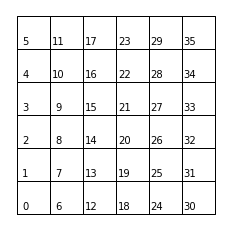

In [2]:
#hacked from https://geographicdata.science/book/notebooks/04_spatial_weights.html#contiguity-weights

# Get points in a grid
l = np.arange(6)
xs, ys = np.meshgrid(l, l)

# Set up store
polys = []

# Generate polygons (flipped x,y to number up/down rather than left/right)
for y, x in zip(xs.flatten(), ys.flatten()):
    poly = Polygon([(x, y), (x+1, y), (x+1, y+1), (x, y+1)])
    polys.append(poly)

# Convert to GeoSeries
polys = gpd.GeoSeries(polys)
sgrid = gpd.GeoDataFrame({'geometry': polys, 
                        'id': [i for i in range(len(polys))]})   

#plot
f,ax = plt.subplots(1,1, subplot_kw=dict(aspect='equal'))
sgrid.plot(facecolor='w', edgecolor='k', ax=ax)
[ax.text(x, y, t, 
          verticalalignment='center',
          horizontalalignment='center') for x, y, t in zip(
         [p.centroid.x-.25 for p in polys],
         [p.centroid.y-.25 for p in polys],
         [i for i in sgrid['id']])]
plt.gca().set_axis_off()

In [3]:
#function to visualise the grids we create
def singlePlot(col, data=sgrid):
    fig, ax = plt.subplots(1,figsize=(4,4))
    sgrid.plot(column=col, edgecolor='w', cmap='viridis_r', ax=ax)
    ax.set_title(col)
    ax.axis('off')
    plt.show()

Generate BW grid for 'positive correlation' (two halves) - Figure 7.5a of O'Sullivan and Unwin (2003):

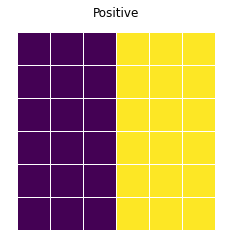

In [4]:
sgrid['Positive'] = np.where(sgrid['id']<18, 1, 0)
singlePlot('Positive')

Generate BW grid for 'negative correlation' (chess board) - Figure 7.5c of O'Sullivan and Unwin (2003):

[1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1]


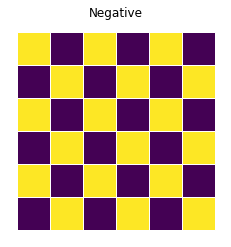

In [5]:
row1 = [1, 0, 1, 0, 1, 0]
row2 = [0, 1, 0, 1, 0, 1]

neg = row1 + row2
neg = neg * 3
print(neg)
sgrid['Negative'] = neg
singlePlot('Negative')

The third grid O'Sullivan and Unwin (2003) present - Figure 7.5b - was created by flipping a coin. Code to reproduce their random grid exactly is provided in the section below on <a href="analyic">Analytic Statistical Significance</a>, but for most of this notebook we will use our own randomly generated grid:

[1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1]


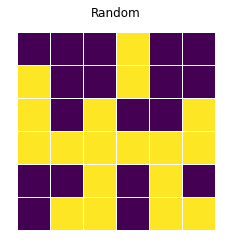

In [6]:
b = [1] * 18
w = [0] * 18
randbw = b + w
np.random.seed(2)  #change seed to generate different outcomes
np.random.shuffle(randbw)
print(randbw)

sgrid['Random'] = randbw
singlePlot('Random')

Let's quickly visualise the DataFrame we've created:

In [7]:
sgrid.head()

,geometry,id,Positive,Negative,Random
0,"POLYGON ((0.00000 0.00000, 1.00000 0.00000, 1....",0,1,1,1
1,"POLYGON ((0.00000 1.00000, 1.00000 1.00000, 1....",1,1,0,1
2,"POLYGON ((0.00000 2.00000, 1.00000 2.00000, 1....",2,1,1,0
3,"POLYGON ((0.00000 3.00000, 1.00000 3.00000, 1....",3,1,0,0
4,"POLYGON ((0.00000 4.00000, 1.00000 4.00000, 1....",4,1,1,0


In our data we have `1`s for B and `0`s for W. 

And we can visualise all the grids together:  <a name="vis"></a>

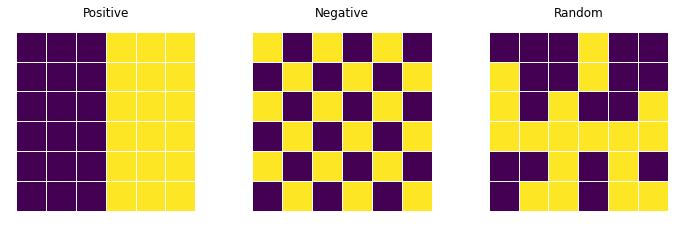

In [8]:
fig, ax = plt.subplots(1,3,figsize=(12, 6))
ax=ax.flatten()
for idx, val in enumerate(list(sgrid.loc[:,'Positive':'Random'])):
    sgrid.plot(column=val, edgecolor='w', cmap='viridis_r', ax=ax[idx])
    ax[idx].set_title(val)
    ax[idx].axis('off')
plt.show()

## Assessing Type of Spatial Autocorrelation <a name="type"></a>

Join counts are a special case of [*Contiguity Spatial Weights*](https://geographicdata.science/book/notebooks/04_spatial_weights.html#contiguity-weights), the difference being that neighbours are now deemed to be 'joined' differently depending on whether they are alike (i.e. both of the same type; BB and WW joins) or unalike (i.e. different types; BW join). However, similar to contiguity weights, we still need to decide whether to use the Queen Rule or the Rook Rule. 

So the first step in calculating join counts with PySAL is to a create spatial weights object using contiguity rules. Here we'll examine both Queen and Rook: 

In [9]:
RW = weights.contiguity.Rook.from_dataframe(sgrid, idVariable='id')
QW = weights.contiguity.Queen.from_dataframe(sgrid, idVariable='id')

Note, that these weights objects are created *irrespective* of B and W values in the grid cells. These spatial weights are concerned with the spatial relationship only; they define neighbours, not joins. The different types of joins (BB, WW, BW) are established by the [`Join_Counts` function](https://pysal.org/esda/generated/esda.Join_Counts.html#esda.Join_Counts), which takes a `weights.contiguity` spatial weights object as an argument. The full list of parameters we can pass `Join_Counts` is as follows:
```
y (array):          binary variable measured across n spatial units
w (W):              spatial weights instance 
permutations (int): number of random permutations for calculation of pseudo-p_values`
```

The default value for `permutations` is 999. We'll see more on this below. 

For now, our first Join Counts object will be created for the *Positive* grid (by passing the `sgrid['Positive']` binary array) and using *Rook Rule* (by passing `RW` contiguity weights object) as follows:

In [10]:
posJCR = esda.join_counts.Join_Counts(sgrid['Positive'], RW)

There are numerous attributes we can access in the `join_count` objects produced, including counts of the different types of joins, the total number of joins, the original data, and estimated p-values to infer if there is significant spatial autocorrelation (or otherwise). 

To get the number (count) of BB joins:

In [11]:
posJCR.bb

27.0

To get the number (count) of WW joins:

In [12]:
posJCR.ww

27.0

To get the number (count) of BW joins:

In [13]:
posJCR.bw

6.0

To get the total number (count) of all types of join:

In [14]:
posJCR.J

60.0

From these values we can get a quick idea of whether there are more alike joins compared to unalike joins, and the sort of proportion those contribute to the total number of joins.   

You should be able to see that in our 'positive' grid the total number of alike joins (54) dominates the number of unalike joins (6). <a href="#vis">See</a> how the six unalike joins are those linking the Black-White cells down the central column of the grid; all other joins are alike (either Black-with-Black or White-with-White). 

Already we can see how the join counts method helps to assess spatial autocorrelation:

- a much greater number of alike joins implies the presence of positive spatial autocorrelation
- a similar number of alike and unalike joins implies a lack of spatial autocorrelation
- a much greater number of unalike joins implies the presence of negative spatial autocorrelation

While this is a quick way to judge for possible spatial autocorrelation, we need to do more calculations to be able to assess whether there is any statistically significant (at a chosen level of confidence) autocorrelation. The two main ways to do this are:

1. <a href="#analytic">Analytically</a> using equations derived from probability theory
2. Using a <a href="#perm">permutation approach</a> with many, many random grids

We need to write some more code to do 1) and an example using Python is shown below. However, the PySAL `join_counts` function does 2) for us, and this approach is more frequently used so we will consider it here first. However, you are encouraged to contine to review the analytical method to help compound your understanding. 

## Assessing Presence of Spatial Autocorrelation (Permutation) <a name="perm"></a>

When investigating spatial autocorrelation, a question we often have is whether the observed configuration (spatial pattern) is statistically significantly different from a random spatial configuration.

One way to assess this is to artifically simulate many, many spatial configurations (permutations) using the same input data set; each permutation takes the observed Black and White regions and shuffles them randomly into spatial locations. You can think of this as repeatedly running the code above that generates the *Random* grid (using a different random seed each time). 

We can then compare our statistic of spatial autocorrelation (e.g. counts of BB) for our observed configuration to the statistic for *all* the permutations. The ratio of the number of times the simulated statistic is greater than (or equal to) the statistic for the observed configuration can then be treated as a *pseudo* p-value for the null hypothesis that there is no difference between simulated (random) and observed statistics: 

*pseudo_P = (C_greater + 1) / (C_permutations + 1)*

where *C_greater* is the count of times statistic *s* is greater than (or equal to) the permutation *s*, and *C_permutations* is the count of permutations. In PySAL, statistic *s* can be the count of BB joins or the count of BW joins (i.e. we can get a pseudo p-value for these statistics). 

So for example, let's check the p-value for BB and BW counts for the `posJCR` grid above, using `.p_sim_bb` and `.p_sim_bw` attributes:

In [15]:
posJCR.p_sim_bb

0.001

In [16]:
posJCR.p_sim_bw

1.0

Remember, hypotheses for [these p-values](https://pysal.org/esda/generated/esda.Join_Counts.html#esda.Join_Counts) are:
- Null: complete spatial randomness
- Alternative: the observed BW or BB is greater than under randomness

So the results above indicate that can be very confident (e.g. 99% confident) that rejecting the null hypothesis for BB is the correct thing to do (because pseudo p < 0.01) but not for BW (because pseudo p >= 0.01). In turn, this means we can say that at 99% confidence there is positive spatial autocorrelation (according to the join counts statistic).  

PySAL enables access to the results of the permutations via `.sim_bb` and `.sim_bw` attributes, so we could check how the pseudo p-values were calculated for ourselves: 

In [17]:
print(posJCR.sim_bb)

[15.0 14.0 18.0 16.0 16.0 14.0 13.0 17.0 15.0 11.0 16.0 12.0 14.0 12.0
 19.0 14.0 14.0 15.0 15.0 15.0 14.0 16.0 17.0 15.0 14.0 16.0 14.0 12.0
 18.0 13.0 16.0 10.0 14.0 15.0 13.0 13.0 14.0 21.0 13.0 14.0 19.0 16.0
 12.0 15.0 13.0 18.0 14.0 18.0 14.0 17.0 16.0 14.0 17.0 11.0 14.0 14.0
 13.0 13.0 14.0 13.0 18.0 14.0 14.0 14.0 9.0 14.0 12.0 18.0 14.0 17.0 10.0
 15.0 12.0 11.0 14.0 13.0 18.0 15.0 15.0 14.0 16.0 15.0 14.0 15.0 13.0
 11.0 15.0 14.0 17.0 13.0 15.0 13.0 12.0 11.0 15.0 16.0 19.0 16.0 15.0
 14.0 16.0 15.0 16.0 15.0 17.0 15.0 17.0 19.0 13.0 14.0 15.0 16.0 13.0
 13.0 16.0 11.0 13.0 16.0 14.0 12.0 15.0 14.0 13.0 17.0 13.0 16.0 14.0
 11.0 15.0 14.0 11.0 14.0 12.0 13.0 13.0 14.0 15.0 15.0 16.0 10.0 15.0
 14.0 17.0 17.0 15.0 15.0 13.0 14.0 13.0 16.0 11.0 13.0 11.0 14.0 12.0
 15.0 14.0 14.0 14.0 13.0 10.0 16.0 13.0 15.0 14.0 18.0 16.0 14.0 12.0
 12.0 14.0 13.0 19.0 15.0 14.0 11.0 15.0 14.0 14.0 15.0 15.0 14.0 18.0
 17.0 12.0 13.0 14.0 13.0 14.0 16.0 15.0 15.0 17.0 12.0 12.0 14.0 13.0
 1

For positive spatial autocorrelation we would expect to observe more BB joins than when generated under complete spatial randomness. Remember that the observed count of BB joins (*countBB*) for our *positive grid* was 27. Check for yourself how many times in the random permutations above we got a *countBB* greater than (or equal to) 27. From a quick scan you should be able to see that the randomly simulated grids (i.e. the permutations) *never* had more than 26 BB joins. 

To check visually, let's plot a histogram of all the simulated counts of BB and compare to our observed BB (the dashed red line):

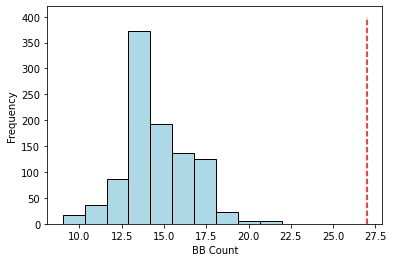

In [18]:
plt.hist(posJCR.sim_bb, 10, facecolor='lightblue', edgecolor='black')
plt.vlines(posJCR.bb, 0, 400, color='r', linestyle="--")
plt.xlabel("BB Count")
plt.ylabel("Frequency")
plt.show()

We can see that our observed 27 BB joins is much greater than we would expect under complete spatial randomness, given the number of B and W cells in our grid. It's very unlikely that our large observed count of 27 BB joins was produced by chance, and hence we get a very small pseudo p-value. 

We can do some final calculations to confirm. First, we count how many times `posJCR.sim_bb >= posJCR.bb` is true:

In [19]:
C_greater = sum(posJCR.sim_bb >= posJCR.bb)

Then we get the number of permutations that were used:

In [20]:
C_permutations= len(posJCR.sim_bb)

#note we could also use the .permutations attribute:
#C_permutations = posJCR.permutations

Now we can calculate the pseudo p-value as above:

In [21]:
pseudo_P = (C_greater + 1) / (C_permutations + 1)
print(pseudo_P)

0.001


This is how PySAL is calculating the pseduo p-value itself!

Now that we have checked the *positive* grid, let's go on to look at the *negative* and *random* grids we created above to check we can interpret the join counts statistics for those too. 

We'll use a function output the results (so we don't need to type code everytime):

In [22]:
#function to output (permutation) results from join_counts object 
def printJointCounts_perm(JCW):
    bcount = JCW.y.sum()
    wcount = len(JCW.y) - bcount
    print("Count Black = " + str(bcount)) 
    print("Count White = " + str(wcount)) 
    print("Total Joins = " + str(JCW.J))
    print("BB Joins: count = " + str(JCW.bb) + ", pseudo p = " + str(round(JCW.p_sim_bb,3)) + ")")
    print("WW Joins: count = " + str(JCW.ww))
    print("BW Joins: count = " + str(JCW.bw) + ", pseudo p = " + str(round(JCW.p_sim_bw,3)) + ")")

Now we can create a `Join_Counts` object for the *Negative Grid* and print the results:

In [23]:
negJCR = esda.join_counts.Join_Counts(sgrid['Negative'], RW)
printJointCounts_perm(negJCR)

Count Black = 18
Count White = 18
Total Joins = 60.0
BB Joins: count = 0.0, pseudo p = 1.0)
WW Joins: count = 0.0
BW Joins: count = 60.0, pseudo p = 0.001)


Here, we get a very small pseudo p-value for the BW joins count, meaning we can reject the null hypothesis of complete spatial randomness (e.g. at 95% confidence) and conclude that there is negative spatial autocorrelation. 

And for the *Random Grid*:

In [24]:
randJCR = esda.join_counts.Join_Counts(sgrid['Random'], RW)
printJointCounts_perm(randJCR)

Count Black = 18
Count White = 18
Total Joins = 60.0
BB Joins: count = 15.0, pseudo p = 0.487)
WW Joins: count = 16.0
BW Joins: count = 29.0, pseudo p = 0.735)


Here, pseudo p-values for both BW and BB joins count are *not* small, meaning we cannot reject the null hypothesis of complete spatial randomness (e.g. at 95% confidence) and we can conclude that there is *no* spatial autocorrelation (neither positive nor negative). 

### A note on WW
You may be wondering why we didn't check the pseudo p-value for WW join counts above. There are two reasons for this, one pragmatic and one theoretical. 

Pragmatically, we didn't because PySAL does not generate permutations for WW joins. So if we wanted to, we would need to write our own code to calculate WW join counts for each permutation and then compare (which maybe you could, using the [source code](https://pysal.org/esda/_modules/esda/join_counts.html#Join_Counts) as a guide).

Theoretically, we don't *need* to generate pseudo p-values for WW. This is because we can assume that whatever result we get for BB will be the same for WW as they have a reciprocal relationship in this binary case. If we have positive spatial autocorrelation for BB then we *must* also have positive spatial autocorrelation for WW. And if we no spatial autocorrelation for BB then we also have no spatial autocorrelation for WW. Finally, the BW measure already accounts for both Black and White regions (so any negative autocorrelation found already applies to both region types).   

### A note of caution

Let's create `join_counts` objects for <a href="#vis">the three grids</a>, but this time using the *Queen Rule*.

In [25]:
posJCQ = esda.join_counts.Join_Counts(sgrid['Positive'], QW)
printJointCounts_perm(posJCQ)

Count Black = 18
Count White = 18
Total Joins = 110.0
BB Joins: count = 47.0, pseudo p = 0.001)
WW Joins: count = 47.0
BW Joins: count = 16.0, pseudo p = 1.0)


In [26]:
negJCQ = esda.join_counts.Join_Counts(sgrid['Negative'], QW)
printJointCounts_perm(negJCQ)

Count Black = 18
Count White = 18
Total Joins = 110.0
BB Joins: count = 25.0, pseudo p = 0.72)
WW Joins: count = 25.0
BW Joins: count = 60.0, pseudo p = 0.299)


In [27]:
randJCQ = esda.join_counts.Join_Counts(sgrid['Random'], QW)
printJointCounts_perm(randJCQ)

Count Black = 18
Count White = 18
Total Joins = 110.0
BB Joins: count = 25.0, pseudo p = 0.724)
WW Joins: count = 27.0
BW Joins: count = 58.0, pseudo p = 0.446)


Compare these results for the Rook Rule to the joins count statistics and pseudo p-values when using the Queen Rule. For example, look to see if there there is positive, negative or no spatial autocorrelation for each grid.  

You should be able to see that results are consistent between Rook and Queen rules for the *Positive* (both indicate positive spatial autocorrelation) and *Random* (no spatial autocorrelation) grids. But for the *Negative* grid note that while the pseudo p-value indicates statistically significant (at 95%) negative spatial autocorrelation for the Rook Rule, the results indicate *no* spatial autocorrelation for the Queen Rule. Think about why the configuration for the *Negative grid* results in this inconsistency. 

As [O'Sullivan and Unwin (2003, p.191)](https://books.google.co.uk/books/about/Geographic_Information_Analysis.html?id=K_kQN-GO7uUC) note,

> Generally, the choice of neighbourhoods [rule] should not affect the scores and the decision about the overal structure, but this is not always the case. ... Despite clearly nonrandom appearance of the [*Negative*] grid, *none* of these [p-values for Queen Rule] indicate any departure from the independent random process! This demonstrates that the joins count statistic must be treated with some caution.

# Application of Join Counts <a name="applied"></a>

To see an application of the Join Counts method with real world data, we'll look at the results of the UK Brexit vote (as presented in [Rey *et al.* 2020](https://geographicdata.science/book/notebooks/06_spatial_autocorrelation.html#an-empirical-illustration-the-eu-referendum)).

As [provided](https://geographicdata.science/book/data/brexit/brexit_cleaning.html) by Rey *et al.* (2020), there are two distinct datasets that will need to be loaded and combined:

- Electoral Comission data on vote percentages at the local authority level. [CSV]
- ONS Local Authority Districts (December 2016) Generalised Clipped Boundaries in the UK WGS84. 

First load the vote percentage data as a pandas df:

In [28]:
brexit_data_path = '../../data/brexit/brexit_vote.csv'
ref = pd.read_csv(brexit_data_path, index_col='Area_Code')
ref.head()

,id,Region_Code,Region,Area,Electorate,ExpectedBallots,VerifiedBallotPapers,Pct_Turnout,Votes_Cast,Valid_Votes,Remain,Leave,Rejected_Ballots,No_official_mark,Voting_for_both_answers,Writing_or_mark,Unmarked_or_void,Pct_Remain,Pct_Leave,Pct_Rejected
Area_Code,,,,,,,,,,,,,,,,,,,,
E06000031,108,E12000006,East,Peterborough,120892,87474,87469,72.35,87469,87392,34176,53216,77,0,32,7,38,39.11,60.89,0.09
E06000032,109,E12000006,East,Luton,127612,84633,84636,66.31,84616,84481,36708,47773,135,0,85,0,50,43.45,56.55,0.16
E06000033,112,E12000006,East,Southend-on-Sea,128856,93948,93939,72.90,93939,93870,39348,54522,69,0,21,0,48,41.92,58.08,0.07
E06000034,113,E12000006,East,Thurrock,109897,79969,79954,72.75,79950,79916,22151,57765,34,0,8,3,23,27.72,72.28,0.04
E06000055,110,E12000006,East,Bedford,119530,86136,86136,72.06,86135,86066,41497,44569,69,0,26,1,42,48.22,51.78,0.08


Next load the local authority district boundaries as a geopandas geodf:

In [29]:
lads = gpd.read_file("../../data/brexit/local_authority_districts.geojson").set_index('lad16cd')
lads.head()

,objectid,lad16nm,lad16nmw,bng_e,bng_n,long,lat,st_areasha,st_lengths,geometry
lad16cd,,,,,,,,,,
E06000001,1,Hartlepool,None,447157,531476,-1.27023,54.676159,0.013041,0.879421,"MULTIPOLYGON (((-1.27024 54.72716, -1.38088 54..."
E06000002,2,Middlesbrough,None,451141,516887,-1.21099,54.544670,0.007484,0.535764,"MULTIPOLYGON (((-1.23001 54.58410, -1.28158 54..."
E06000003,3,Redcar and Cleveland,None,464359,519597,-1.00611,54.567520,0.034014,1.266847,"MULTIPOLYGON (((-1.13716 54.64693, -1.13256 54..."
E06000004,4,Stockton-on-Tees,None,444937,518183,-1.30669,54.556911,0.028479,1.424195,"MULTIPOLYGON (((-1.31774 54.64524, -1.38088 54..."
E06000010,10,"Kingston upon Hull, City of",None,511894,431716,-0.30380,53.769791,0.009740,0.782168,"MULTIPOLYGON (((-0.31613 53.81325, -0.35366 53..."


And then `join` the df to the geodf (the two df have the same index, using local autority district codes) and select only the columns we need for the analysis:

In [30]:
gdf = gpd.GeoDataFrame(lads.join(ref[['Pct_Leave']]), crs=lads.crs)
gdf = gdf[['objectid', 'lad16nm', 'Pct_Leave', 'geometry']].dropna()
gdf.head()

,objectid,lad16nm,Pct_Leave,geometry
lad16cd,,,,
E06000001,1,Hartlepool,69.57,"MULTIPOLYGON (((-1.27024 54.72716, -1.38088 54..."
E06000002,2,Middlesbrough,65.48,"MULTIPOLYGON (((-1.23001 54.58410, -1.28158 54..."
E06000003,3,Redcar and Cleveland,66.19,"MULTIPOLYGON (((-1.13716 54.64693, -1.13256 54..."
E06000004,4,Stockton-on-Tees,61.73,"MULTIPOLYGON (((-1.31774 54.64524, -1.38088 54..."
E06000010,10,"Kingston upon Hull, City of",67.62,"MULTIPOLYGON (((-0.31613 53.81325, -0.35366 53..."


Let's quickly visualise the vote percentage data:

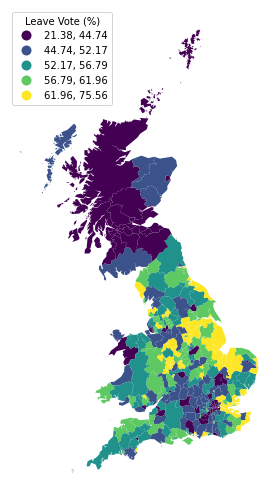

In [31]:
fig, ax = plt.subplots(1, figsize=(9, 9))
gdf.plot(column='Pct_Leave', cmap='viridis', 
        scheme='quantiles', k=5, 
        linewidth=0., 
        legend=True, legend_kwds={"title":"Leave Vote (%)","loc": 2},
        ax=ax
       )
ax.set_axis_off()

To use the Joins Count method we need a binary map. Let's create that using 50% as the vote percentage to define districts that voted to leave vs remain in the EU:  

In [32]:
gdf['Leave'] = (gdf['Pct_Leave'] > 50).astype(int)
gdf.tail()

,objectid,lad16nm,Pct_Leave,geometry,Leave
lad16cd,,,,,
W06000018,385,Caerphilly,57.63,"POLYGON ((-3.30131 51.79897, -3.31009 51.79430...",1
W06000019,386,Blaenau Gwent,62.03,"POLYGON ((-3.24823 51.81515, -3.31009 51.79430...",1
W06000021,388,Monmouthshire,49.56,"MULTIPOLYGON (((-3.05214 51.97294, -3.06736 51...",0
W06000022,389,Newport,55.99,"MULTIPOLYGON (((-2.83439 51.64824, -2.88647 51...",1
W06000023,390,Powys,53.74,"POLYGON ((-3.15484 52.89808, -3.23300 52.86699...",1


And let's map that new binary variable:

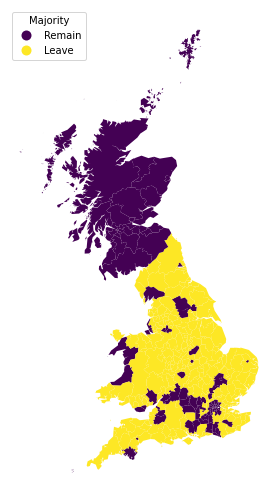

In [33]:
fig, ax = plt.subplots(1, figsize=(9, 9))
gdf.plot(column='Leave', cmap='viridis', 
         categorical=True, linewidth=0., 
         legend=True, legend_kwds={"title":"Majority","loc": 2},
        ax=ax)
ax.set_axis_off()
ax.get_legend().get_texts()[0].set_text("Remain")
ax.get_legend().get_texts()[1].set_text("Leave")
plt.show()

This is the equivalent of our grids above. From looking at the map, do you think there is a presence of spatial autocorrelation? If so, do you think it is positive or negative? (i.e. are alike districts more clustered or dispersed?)

To calculate our join counts we need to create a spatial weights object. We'll use K Nearest Neighbours with `k=8` (you could try different values of `k` or different types of neighbour relation): 

In [34]:
w = weights.KNN.from_dataframe(gdf, k=16)

In [35]:
w = weights.contiguity.Queen.from_dataframe(gdf)

And now we can create our Join Counts object:

In [36]:
np.random.seed(1234)
jc = esda.join_counts.Join_Counts(gdf['Leave'], w)

As above for our simple grid we can check the counts of the different types of join:

In [37]:
jc.bb

556.0

In [38]:
jc.bb

556.0

In [39]:
jc.ww

171.0

In [40]:
jc.ww

171.0

In [41]:
jc.bw

211.0

In [42]:
jc.bw

211.0

In [43]:
jc.J

938.0

In [44]:
jc.J

938.0

From looking at the counts (relative to the total number of joins) do you think spatial autocorrelation is present? 

Let's examine the pseudo p-values to check:

In [45]:
jc.p_sim_bb

0.001

In [46]:
jc.p_sim_bb

0.001

In [47]:
jc.p_sim_bw

1.0

In [48]:
jc.p_sim_bw

1.0

Remember, hypotheses for [these p-values](https://pysal.org/esda/generated/esda.Join_Counts.html#esda.Join_Counts) are:
- Null: complete spatial randomness
- Alternative: the observed BW or BB is greater than under randomness

So the results above indicate that at 95% confidence we can reject the null hypothesis for BB (because pseudo p < 0.05) but not for BW (because pseudo p >= 0.05). In turn, this means we can say that at 95% confidence there is positive spatial autocorrelation (according to the join counts statistic). That is, districts are more clustered than dispersed in their voting tendency. 

Finally, we can confirm that our observed BB count is larger than expected by change by visualising it compared to the distribution of randomly simulated maps (using the observed proportions of districts voting leave vs remain). 

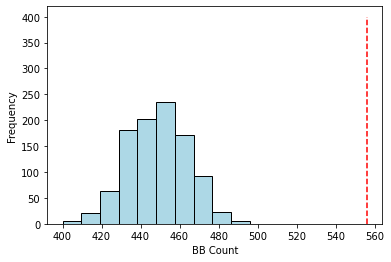

In [49]:
plt.hist(jc.sim_bb, 10, facecolor='lightblue', edgecolor='black')
plt.vlines(jc.bb, 0, 400, color='r', linestyle="--")
plt.xlabel("BB Count")
plt.ylabel("Frequency")
plt.show()

The observed count of alike joins between neighbouring districts certainly seems to be much greater than we would expect by chance. 

# Bonus Theory!

This is an optional section for those of you who really want to compound your understanding. This final section revisits the <a href="#type">Join Counts Theory section</a> to examine the second approach to assessing statistical significance (i.e. whether observations are different from complete spatial randomeness). 

## Assessing Presence of Spatial Autocorrelation (Analytic) <a name="analytic"></a>

In Chapter 7 of the **2003** edition of their book *Geographic Information Analysis*, [O'Sullivan and Unwin provide a detailed work through](https://github.com/jamesdamillington/john-snow/blob/main/pdf/OSullivanUnwin2003_Section7_4.pdf) of the analytic approach to deriving z-scores (i.e. using equations rather than the permuation approach above). The code below provides a python implementation of the equations therein. A short discussion is provided below the code, showing their use and commenting on interpretation. 

In [50]:
def calcM(weightsObject):

    #function to calculate Eq 7.26 OSU (2003) 

    cumsum=0
    for a in weightsObject:

        #a is the weights for each location (all 1s)
        nbs = list(a[1].values())  #get these weights as a list

        #replace the elements of the list with the length of the list -1
        for i,n in enumerate(nbs):
            nbs[i] = len(nbs)-1

        #cumulative sum of the new values
        cumsum+=np.sum(nbs)

    #return 0.5*cusmsum
    return(cumsum*0.5)

In [51]:
def calcpB(JCW):
    #OSU (2003) assume pB = 0.5 but note normally it would be estimated from the data 
    return(0.5)
    #one way to estimate from data (assumes Black is coded 1): 
    #sum of y / length of y   [count B / count cells]
    #return(JCW.y.sum()/len(JCW.y))
    

def calcpW(JCW):
    #OSU (2003) assume pW = 0.5 but note normally it would be estimated from the data 
    return(0.5)
    #one way to estimate from data (assumes White is coded 0)
    #length of y - (sum of y / length of y)   [count cells - (count B / count cells)]
    #return((len(JCW.y) - JCW.y.sum())/len(JCW.y))

In [52]:
def calcExpectedBB(JCW):
    #kpB^2 from Eq 7.24 OSU (2003)
    return(JCW.J*calcpB(JCW)**2)

def calcExpectedWW(JCW):
    #kpW^2 from Eq 7.24 OSU (2003)
    return(JCW.J*calcpW(JCW)**2)

def calcExpectedBW(JCW):
    #2kpBpW from Eq 7.24 OSU (2003)
    return(2*JCW.J*calcpB(JCW)*calcpW(JCW))

In [53]:
def calcStdDevBB(JCW):
    #Eq 7.29 OSU (2003)
    f=calcExpectedBB(JCW)
    s=2*calcM(JCW.w)*calcpB(JCW)**3
    t=(JCW.J + (2*calcM(JCW.w)))*calcpB(JCW)**4
    
    return(np.sqrt(f+s-t))

def calcStdDevWW(JCW):
    #Eq 7.29 OSU (2003)
    return(calcStdDevBB(JCW))

def calcStdDevBW(JCW):
    #Eq 7.30 OSU (2003)
    f=2*(JCW.J+calcM(JCW.w))*calcpB(JCW)*calcpW(JCW)
    s=4*(JCW.J+(2*calcM(JCW.w)))*calcpB(JCW)**2*calcpW(JCW)**2
    
    return(np.sqrt(f-s))

In [54]:
def calcZBB(JCW):
    #(observed - expected) / StdDev
    return((JCW.bb - calcExpectedBB(JCW)) / calcStdDevBB(JCW))

def calcZWW(JCW):
    #(observed - expected) / StdDev
    return((JCW.ww - calcExpectedWW(JCW)) / calcStdDevWW(JCW))

def calcZBW(JCW):
    #(observed - expected) / StdDev
    return((JCW.bw - calcExpectedBW(JCW)) / calcStdDevBW(JCW))

In [55]:
#function to output results from join_counts object, with z-scores 
def printJointCounts(JCW):
    bcount = JCW.y.sum()
    wcount = len(JCW.y) - bcount
    print("Count Black = " + str(bcount)) 
    print("Count White = " + str(wcount)) 
    print("Total Joins = " + str(JCW.J))
    print("BB Joins: count = " + str(JCW.bb) + ",\t z = ", str(round(calcZBB(JCW),3)) + ")")
    print("WW Joins: count = " + str(JCW.ww) + ",\t z = ", str(round(calcZWW(JCW),3)) + ")")
    print("BW Joins: count = " + str(JCW.bw) + ",\t z = ", str(round(calcZBW(JCW),3)) + ")")

The code above allows us to analystically calculate z-scores for the different count types. For example, for the *positive* and *negative* grids using Rook Rule: 

In [56]:
printJointCounts(posJCR)

Count Black = 18
Count White = 18
Total Joins = 60.0
BB Joins: count = 27.0,	 z =  2.2)
WW Joins: count = 27.0,	 z =  2.2)
BW Joins: count = 6.0,	 z =  -6.197)


In [57]:
printJointCounts(negJCR)

Count Black = 18
Count White = 18
Total Joins = 60.0
BB Joins: count = 0.0,	 z =  -2.75)
WW Joins: count = 0.0,	 z =  -2.75)
BW Joins: count = 60.0,	 z =  7.746)


We will also generate the random grid O'Sullivan and Unwin (2003) create to allow direct comparison with their results:

[1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1]


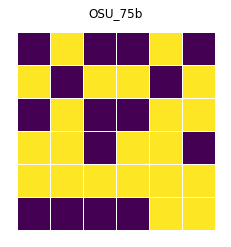

In [58]:
osuids = [0, 3, 5, 6, 10, 12, 14, 15, 17, 18, 21, 23, 28, 32, 35]
osu = [0] * 36
for i in range(0,len(osu)):
    if(i in osuids):
        osu[i] = 1
print(osu)
sgrid['OSU_75b'] = osu
singlePlot('OSU_75b')

In [59]:
osuJCR = esda.join_counts.Join_Counts(sgrid['OSU_75b'], RW)
printJointCounts(osuJCR)

Count Black = 15
Count White = 21
Total Joins = 60.0
BB Joins: count = 6.0,	 z =  -1.65)
WW Joins: count = 19.0,	 z =  0.733)
BW Joins: count = 35.0,	 z =  1.291)


From the results from these three grids you should be able to see how the z-scores match Table 7.2 of O'Sullivan and Unwin (2003).

We could take this a step further and compare the z-scores to a normal distribution to calculate a p-value. For example: 

In [60]:
import scipy.stats
z = calcZWW(posJCR)
p = scipy.stats.norm.sf(abs(z))
print(round(p,3))

0.014


However, [Cliff et al. (1974, p.110)](https://doi.org/10.2307/621612) note;

> Provided that the distribution of the test statistic is approximately normal for the county system under consideration, Eq (1.3) [used above in `calcZ` functions] can be treated as a standard normal deviate. Cliff and Ord (1973, chapter 2) have shown that the approximation is reasonable for moderate *n*, provided that P(X = 1) is not too near 0 or 1, and the county system is not dominated by few counties. However, for many county systems of practical interest, such as the counties of England, Wales or Scotland, the states of the United States, or the counties of Western Europe, *n* is sufficiently small for the normal distribution to be misleading. 

In the cases used here, our *n* is likely not sufficiently large and we should use a chi-square. 

In general, when calculating joins counts with PySAL it is fine to use the pseudo p-values from the permutation approach, and greater uncertainty may actually arise from choice of Contiguity Rule (so given how fast it is to compute, it's often worth comparing results between Rook and Queen rules). 

# Credits!

## Contributors:
The following individual(s) have contributed to these teaching materials: James Millington (james.millington@kcl.ac.uk).

## License
These teaching materials are licensed under a mix of [The MIT License](https://opensource.org/licenses/mit-license.php) and the [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 license](https://creativecommons.org/licenses/by-nc-sa/4.0/).